<a href="https://colab.research.google.com/github/chcorophyll/my_deeplearning_cookbook/blob/master/my_Activation_Optimization_and_Neural_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chcorophyll/deep_learning_cookbook.git

Cloning into 'deep_learning_cookbook'...
remote: Enumerating objects: 427, done.
remote: Total 427 (delta 0), reused 0 (delta 0), pack-reused 427
Receiving objects: 100% (427/427), 160.26 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Checking out files: 100% (86/86), done.


**Activation Optimization**

In [0]:
!ls

deep_learning_cookbook	sample_data


In [0]:
import os 

path_org = os.getcwd()
path_data = os.path.join(path_org, "deep_learning_cookbook")
os.chdir(path_data)

In [0]:
import numpy as np
import PIL
import random

import time
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

from itertools import islice
from tqdm import tqdm
import scipy
from scipy import ndimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
    
from IPython.display import clear_output, Image, display

Using TensorFlow backend.


In [0]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img
    
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == "channels_first":
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[-3], x.shape[-2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype("unit8")
    return x

In [0]:
model = vgg16.VGG16(weights="imagenet", include_top=False)
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print("Model loaded")

model.summary()

W0708 08:06:22.843600 140280596686720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 08:06:22.885253 140280596686720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 08:06:22.892903 140280596686720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 08:06:22.930022 140280596686720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0708 08:06:24.229299 140280596686720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 08:06:24.230286 140280596686720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0       

In [0]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def showarray(a, fmt='png'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def visstd(a, s=0.1):
    '''Normalize and clip the image range for visualization'''
    a = (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5
    return np.uint8(np.clip(a, 0, 1) * 255)

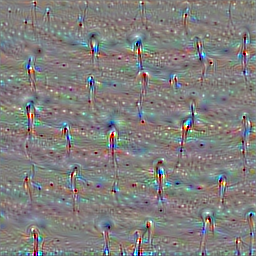

In [0]:
input_img = model.input
filter_index = 7

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = "block5_conv1"

# we build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
if K.image_data_format() == "channels_first":
    loss = K.mean(layer_output[:, filter_index, :, :])
else:
    loss = K.mean(layer_output[:, :, :, filter_index])
    
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function return the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1

# we start from a gray image with some random noise
if K.image_data_format() == "channels_first":
    img_data = np.random.uniform(size=(1, 3, 256, 256)) + 128
else:
    img_data = np.random.uniform(size=(1, 256, 256, 3)) + 128.
    
# we run gradient ascent for 50 steps
for i in range(50):
    loss_value, grads_value = iterate([img_data])
    img_data += grads_value * step
    
showarray(visstd(img_data[0]))

In [0]:
img_data = np.random.uniform(size=(1, 128, 128, 3)) + 128
img_data.shape

(1, 128, 128, 3)

In [0]:
layer_output = layer_dict["block5_conv1"].output
loss = K.mean(layer_output[:, :, :, 7])
print("grads shape:", len(K.gradients(loss, input_img)))
grads = K.gradients(loss, input_img)[0]
print(grads.shape)
print(loss.shape)

grads shape: 1
(?, ?, ?, 3)
()


In [0]:
sample_size = 100
grid = []
layers = [layer_dict["block%d_conv%d" % (i, (i+2)//3)] for i in range(1, 6)]

for layer in layers:
    row = []
    neurons = list(range(max(x or 0 for x in layer.output_shape)))
    if len(neurons) > sample_size:
        neurons = random.sample(neurons, sample_size)
    for neuron in tqdm(neurons, desc=layer.name):
        if K.image_data_format() == "channels_first":
            loss = K.mean(layer.output[:, neuron, :, :])
        else:
            loss = K.mean(layer.output[:, :, :, neuron])
            
        grads = K.gradients(loss, input_img)[0]
        grads = normalize(grads)
        iterate = K.function([input_img], [loss, grads])
        if K.image_data_format() == "channels_first":
            img_data = np.random.uniform(size=(1, 3, 128, 128)) + 128
        else:
            img_data = np.random.uniform(size=(1, 128, 128, 3)) + 128
        for i in range(25):
            loss_value, grads_value = iterate([img_data])
            img_data += grads_value
        row.append((loss_value, img_data[0]))
    grid.append([cell[1] for cell in islice(sorted(row, key=lambda t: -t[0]), 10)])

block5_conv2: 100%|██████████| 100/100 [03:21<00:00,  2.45s/it]


In [0]:
grid[0][1].shape

(128, 128, 3)

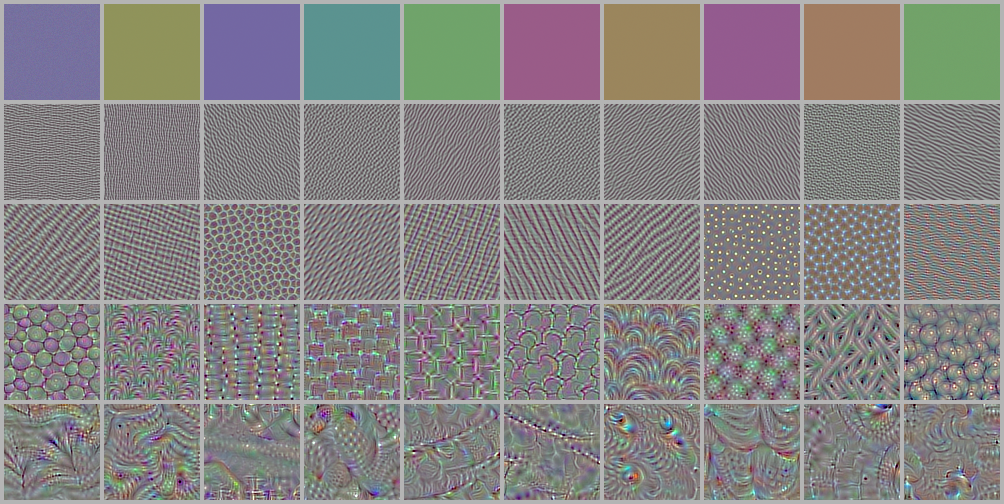

In [0]:
cols = 10
img_grid = PIL.Image.new("RGB", (cols*100+4, len(layers)*100+4), (180, 180, 180))
for y in range(len(layers)):
    for x in range(cols):
        sub = PIL.Image.fromarray(visstd(grid[y][x])).crop((16, 16, 112, 112))
        img_grid.paste(sub, (x*100+4, (y*100)+4))
        
display(img_grid)

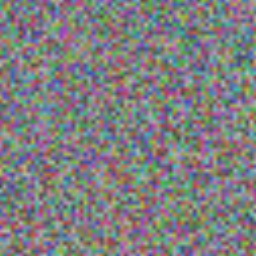

In [0]:
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == "channels_first":
        factors = (1, 1, float(size[0])/img.shape[2], float(size[1])/img.shape[3])
    else:
        factors = (1, float(size[0])/img.shape[1], float(size[1])/img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

if K.image_data_format() == "channels_first":
    img_data = np.random.uniform(size=(3, 64, 64, 3)) + 128
else:
    img_data = np.random.uniform(size=(3, 64, 64, 3)) + 128
    
img2 = resize_img(img_data, (256, 256))
showarray(visstd(img2[0]))

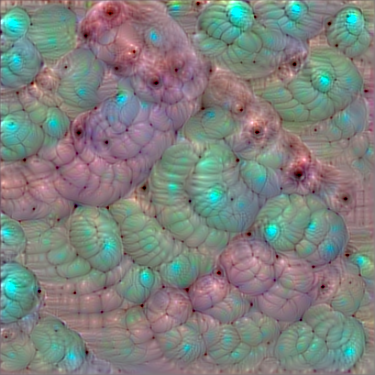

In [0]:
size = 64
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, size, size)) + 128.
else:
    img_data = np.random.uniform(size=(1, size, size, 3)) + 128.
    
layer = layer_dict["block5_conv1"]
neuron =4

if K.image_data_format() == "channels_first":
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

for octave in range(20):
    if octave > 0:
        size = int(size*1.1)
        img_data = resize_img(img_data, (size, size))
    for i in range(10):
        loss_value, grads_value = iterate([img_data])
        img_data += grads_value
    clear_output()
    showarray(visstd(img_data[0]))

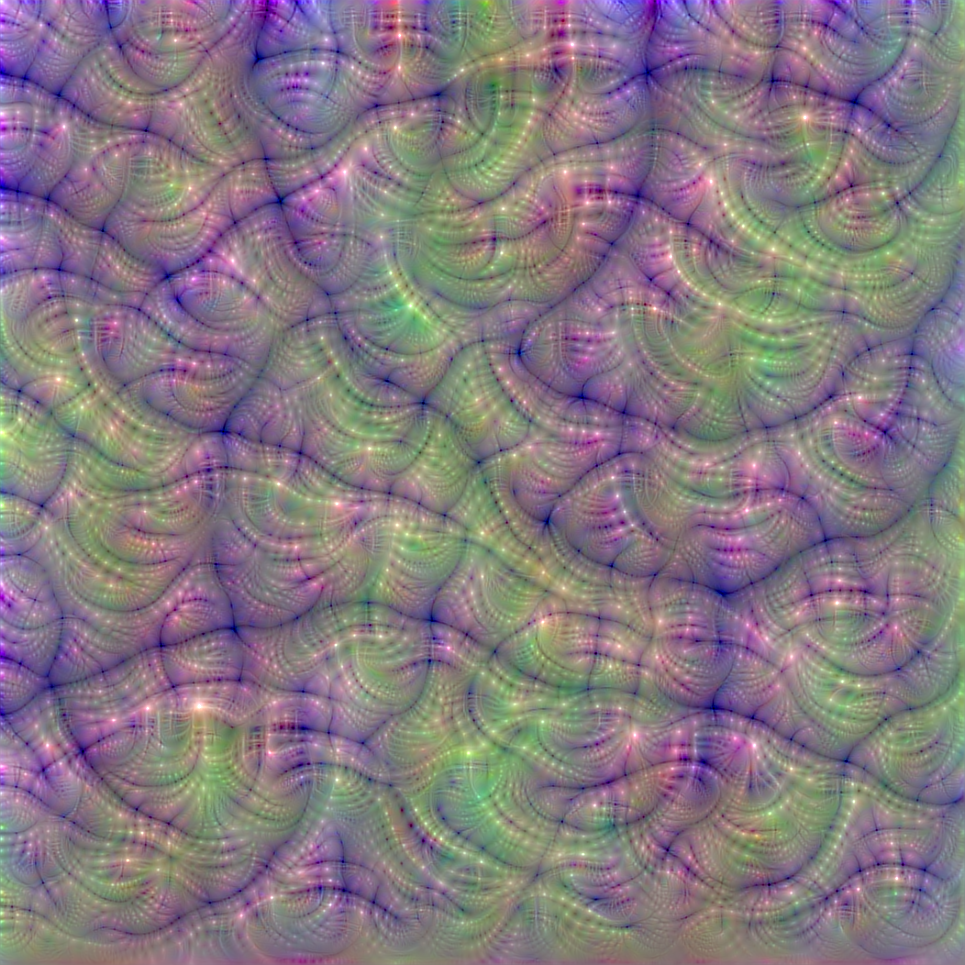

In [0]:
size = 64
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, size, size)) + 128.
else:
    img_data = np.random.uniform(size=(1, size, size, 3)) + 128.

layer = layer_dict['block5_conv1']

#Things to try: 4, 21, 25, 34, 38, 39, 44, 49, 50
neuron = 53
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

for octave in range(30):
    if octave > 0:
        size = int(size*1.1)
        img_data = resize_img(img_data, (size, size))
    for i in range(10):
        loss_value, grads_value = iterate([img_data])
        sigma = (1 - octave*0.03) * 3
        if K.image_data_format() == "channels_first":
            grads_value[0, 0, :, :] = ndimage.gaussian_filter(grads_value[0, 0, :, :], sigma=sigma)
            grads_value[0, 1, :, :] = ndimage.gaussian_filter(grads_value[0, 1, :, :], sigma=sigma)
            grads_value[0, 2, :, :] = ndimage.gaussian_filter(grads_value[0, 2, :, :], sigma=sigma)
        else:
            grads_value[0, :, :, 0] = ndimage.gaussian_filter(grads_value[0, :, :, 0], sigma=sigma)
            grads_value[0, :, :, 1] = ndimage.gaussian_filter(grads_value[0, :, :, 1], sigma=sigma)
            grads_value[0, :, :, 2] = ndimage.gaussian_filter(grads_value[0, :, :, 2], sigma=sigma)
        img_data += grads_value
    clear_output()
    showarray(visstd(img_data[0]))

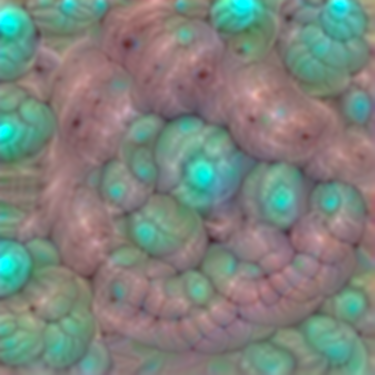

In [0]:
size = 64
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, size, size)) + 128.
else:
    img_data = np.random.uniform(size=(1, size, size, 3)) + 128.

layer = layer_dict['block5_conv1']
neuron = 4
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

for octave in range(20):
    if octave>0:
        size = int(size * 1.1)
        img_data = resize_img(img_data, (size, size))
    for i in range(10):
        loss_value, grads_value = iterate([img_data])
        if K.image_data_format() == 'channels_first':
            grads_value[0, 0, :, :] = ndimage.gaussian_filter(grads_value[0, 0, :, :], sigma=2)
            grads_value[0, 1, :, :] = ndimage.gaussian_filter(grads_value[0, 1, :, :], sigma=2)
            grads_value[0, 2, :, :] = ndimage.gaussian_filter(grads_value[0, 2, :, :], sigma=2)
        else:
            grads_value[0, :, :, 0] = ndimage.gaussian_filter(grads_value[0, :, :, 0], sigma=2)
            grads_value[0, :, :, 1] = ndimage.gaussian_filter(grads_value[0, :, :, 1], sigma=2)
            grads_value[0, :, :, 2] = ndimage.gaussian_filter(grads_value[0, :, :, 2], sigma=2)
        img_data += grads_value
    clear_output()
    showarray(visstd(img_data[0]))

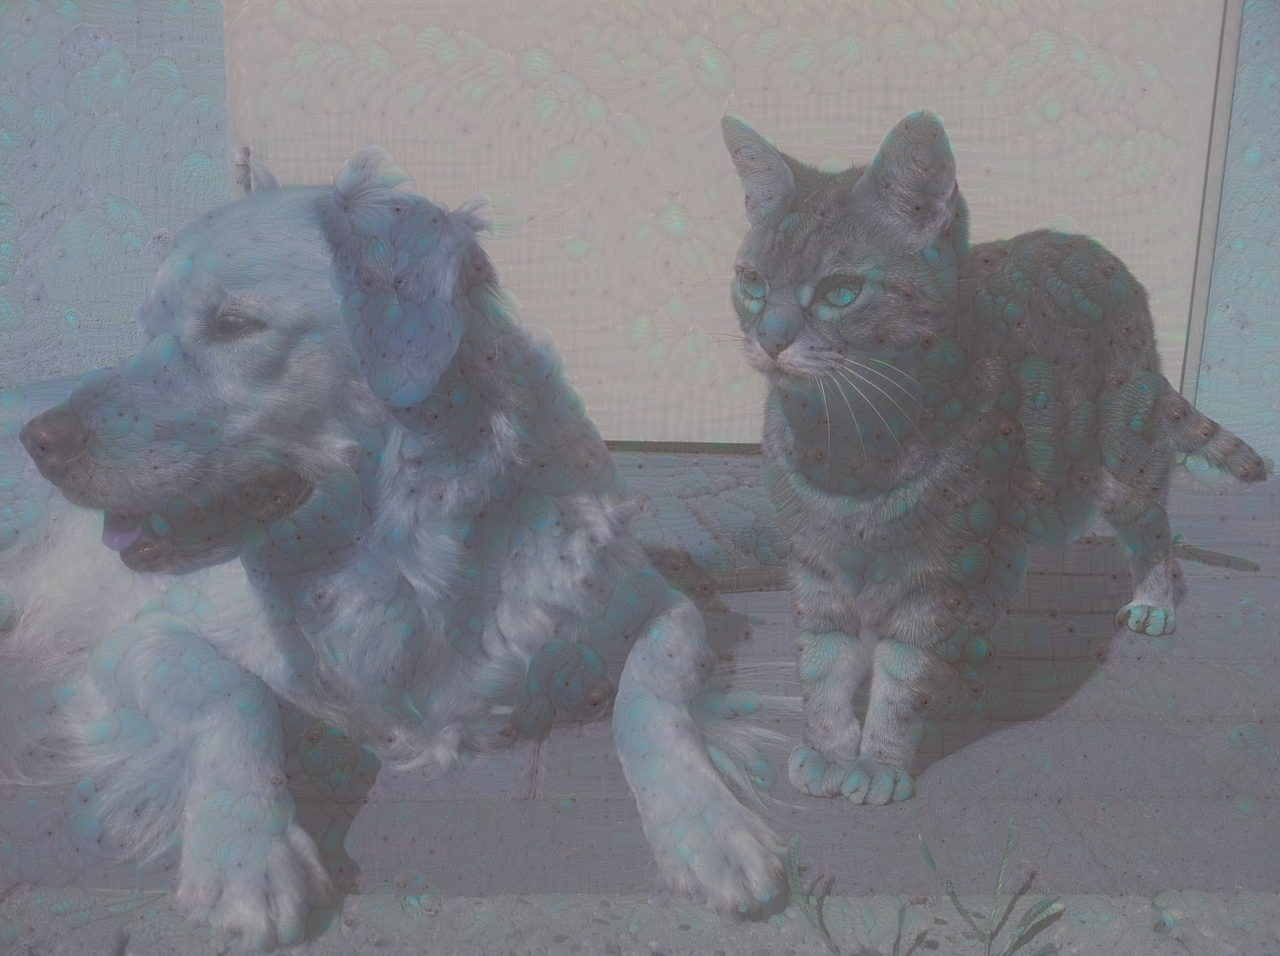

In [0]:
layer = layer_dict["block5_conv1"]
neuron = 4
if K.image_data_format() == "channels_first":
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

num_octave = 5 # Number of scales at which to run gradient ascent
octave_scale = 1.2 # Size ratio between scales

img = preprocess_image("data/cat_dog.jpg")

if K.image_data_format() == "channels_first":
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]

successive_shapes = [tuple(int(dim/(octave_scale**i)) for dim in original_shape)
                     for i in range(num_octave-1, -1, -1)]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    img = resize_img(img, shape)
    for i in range(20):
        loss_value, grads_value = iterate([img])
        img += grads_value * 0.2
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    clear_output()
    showarray(visstd(img[0]))

In [0]:
img = preprocess_image("data/cat_dog.jpg")
original_shape = img.shape[1:3]
original_shape

(956, 1280)

In [0]:
img.shape

(1, 956, 1280, 3)

In [0]:
list(range(num_octave-1, -1, -1))

[4, 3, 2, 1, 0]

In [0]:
successive_shapes

[(461, 617), (553, 740), (663, 888), (796, 1066), (956, 1280)]

In [0]:
shrunk_original_img = resize_img(img, successive_shapes[0])
shrunk_original_img.shape

(1, 461, 617, 3)

In [0]:
upscaled_shrunk_original_img = resize_img(shrunk_original_img, successive_shapes[0])
upscaled_shrunk_original_img.shape

(1, 461, 617, 3)

In [0]:
original_img = np.copy(img)
same_size_original = resize_img(original_img, successive_shapes[0])
same_size_original.shape

(1, 461, 617, 3)

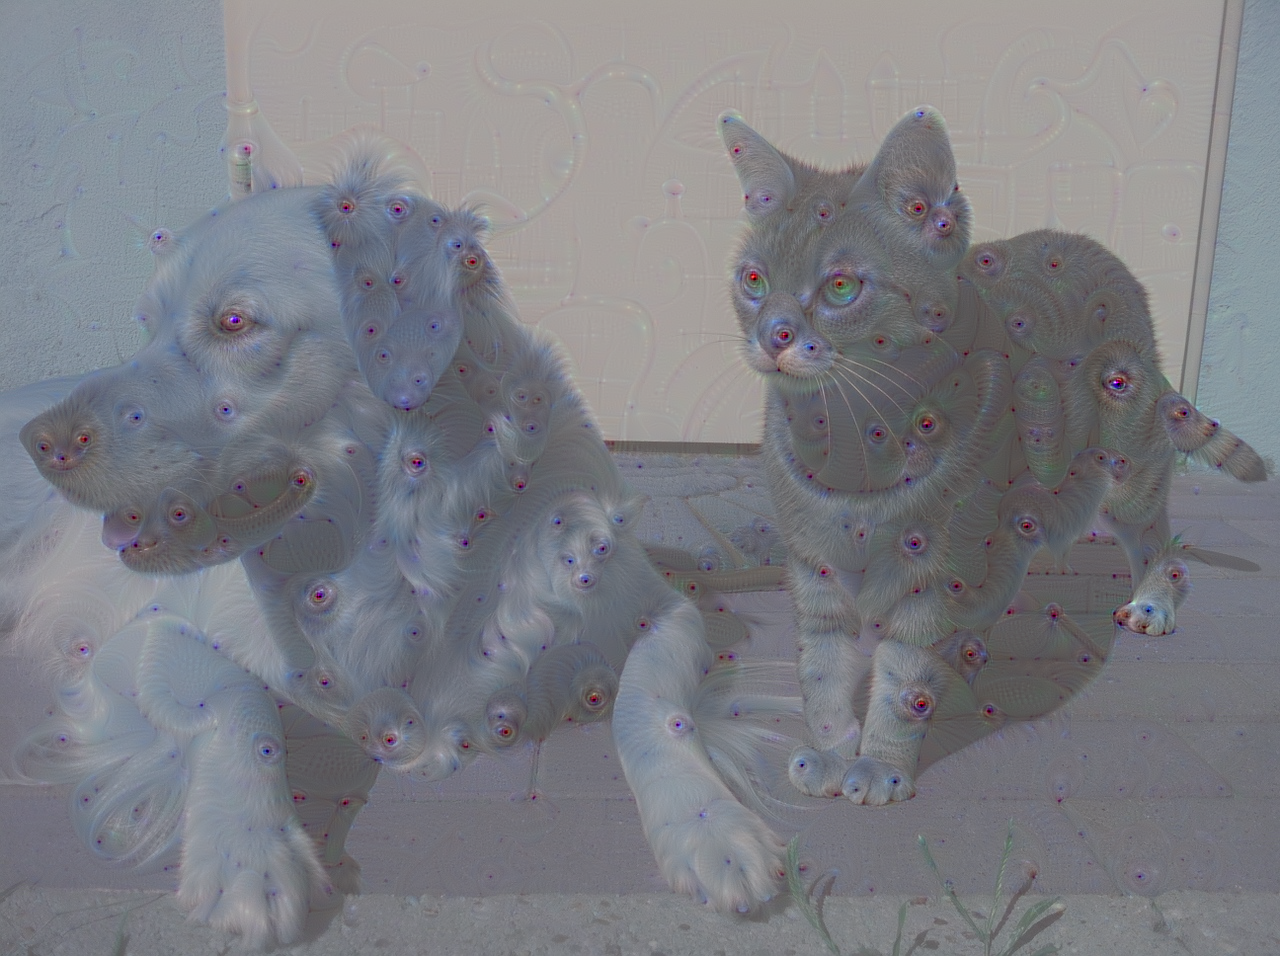

In [0]:
settings = {"block3_pool": 0.1, 
            "block4_pool": 1.2, 
            "block5_pool": 1.5,}

# Define the loss
loss = K.variable(0.)
for layer_name, coeff in settings.items():
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), "float32"))
    if K.image_data_format() == "channels_first":
        loss += coef * K.sum(K.square(x[:,:,2:-2,2:-2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

grads = K.gradients(loss, input_img)[0]
# grads = normalize(grads)
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
iterate = K.function([input_img], [loss, grads])

num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.2  # Size ratio between scales

img = preprocess_image('data/cat_dog.jpg')
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [tuple(int(dim / (octave_scale ** i)) 
                     for dim in original_shape) for i in range(num_octave - 1, -1, -1)]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    img = resize_img(img, shape)
    for i in range(20):
        loss_value, grads_value = iterate([img])
        img += grads_value * 0.10
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    clear_output()
    showarray(visstd(img[0]))

**Neural Style**


In [0]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16, vgg19
from keras import backend as K
import numpy as np
import time
import glob
import imageio
from scipy.optimize import fmin_l_bfgs_b
from itertools import combinations
# from scipy.misc import imread, imsave, fromimage, toimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO  as BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [0]:
base_image_path = "style_transfer/Okerk2.jpg"
style1_image_path = "style_transfer/water-lilies-1919-2.jpg"
style2_image_path = "style_transfer/VanGogh-starry_night_ballance1.jpg"

In [0]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess_image(image_path, target_size=None):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x, w, h):
    if K.image_data_format() == "channels_first":
        x = x.reshape((3, w, h))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((w, h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    return x

In [7]:
w, h = 740, 468
style_image = K.variable(preprocess_image(style1_image_path, target_size=(h, w)))
result_image = K.placeholder(style_image.shape)
input_tensor = K.concatenate([style_image, result_image], axis=0)
input_tensor.shape

W0708 12:02:49.219539 140378524911488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



TensorShape([Dimension(2), Dimension(468), Dimension(740), Dimension(3)])

In [8]:
model = vgg16.VGG16(input_tensor=input_tensor, weights="imagenet", include_top=False)
print("Model loaded")

W0708 12:05:50.742403 140378524911488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 12:05:50.745613 140378524911488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 12:05:50.805859 140378524911488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 6s 0us/step


W0708 12:05:58.333988 140378524911488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 12:05:58.335813 140378524911488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Model loaded


In [0]:
class Evaluator(object):
    def __init__(self, loss_total, result_image, **other):
        grads = K.gradients(loss_total, result_image)
        outputs = [loss_total] + list(other.values()) + grads
        self.iterate = K.function([result_image], outputs)
        self.other = list(other.keys())
        self.other_values = {}
        self.shape = result_image.shape
        
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        outs = self.iterate([x.reshape(self.shape)])
        self.loss_value = outs[0]
        self.grad_values = outs[-1].flatten().astype("float64")
        self.other_values = dict(zip(self.other, outs[1:-1]))
        return self.loss_value
    
    def grads(self, x):
        return np.copy(self.grad_values)

In [0]:
def gram_matrix(x):
    if K.image_data_format() != "channels_first":
        x = K.permute_dimensions(x, (2, 0, 1))
    features = K.batch_flatten(x)
    return K.dot(features-1, K.transpose(features-1)) - 1

def style_loss(layer_1, layer_2):
    gr1 = gram_matrix(layer_1)
    gr2 = gram_matrix(layer_2)
    return K.sum(K.square(gr1- gr2)) / (np.prod(layer_2.shape).value ** 2 )

In [13]:
feature_outputs = [layer.output for layer in model.layers if "_conv" in layer.name]
loss_style = K.variable(0)
for idx, layer_features in enumerate(feature_outputs):
    loss_style += style_loss(layer_features[0, :, :, :], layer_features[1, :, :, :])
style_evaluator = Evaluator(loss_style, result_image)    

W0708 12:45:19.989304 140378524911488 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
def run(evaluator, image, num_iter=25):
    for i in range(num_iter):
        start_time = time.time()
        image, min_val, info = fmin_l_bfgs_b(evaluator.loss, image.flatten(), 
                                             fprime=evaluator.grads, maxfun=20)
        end_time = time.time()
        clear_output()
        showarray(deprocess_image(image.copy(), h, w))
        
        print("Iteration %d completed in %ds" % (i + 1, end_time - start_time))
        print("Current loss value:", min_val)
        print(' '.join(k + ':' + str(evaluator.other_values[k]) for k in evaluator.other))
        
    return image

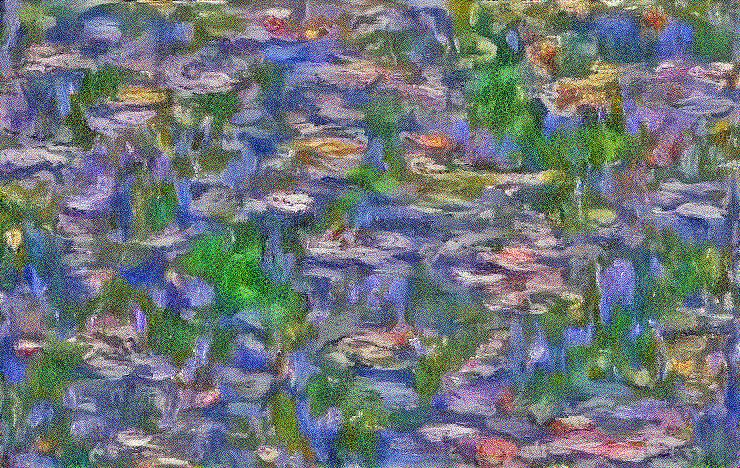

Iteration 50 completed in 19s
Current loss value: 7976367.5



In [15]:
x = np.random.uniform(0, 255, result_image.shape) - 128.
res = run(style_evaluator, x, num_iter=50)

In [0]:
def total_variation_loss(x, exp=1.25):
    _, d1, d2, d3 = x.shape
    if K.image_data_format() == "channels_first":
        a = K.square(x[:, :, :d2 - 1, :d3 - 1] - x[:, :, 1:, :d3 - 1])
        b = K.square(x[:, :, :d2 - 1, :d3 - 1] - x[:, :, :d2 - 1, 1:])
    else:
        a = K.square(x[:, :d1 - 1, :d2 - 1, :] - x[:, 1:, :d2 - 1, :])
        b = K.square(x[:, :d1 - 1, :d2 - 1, :] - x[:, :d1 - 1, 1:, :])
    return K.sum(K.pow(a + b, exp))        

In [17]:
loss_variation = total_variation_loss(result_image) / 5000
loss_with_variation = loss_variation + loss_style
evaluator_with_variation = Evaluator(loss_with_variation, result_image)

W0708 13:30:15.862987 140378524911488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


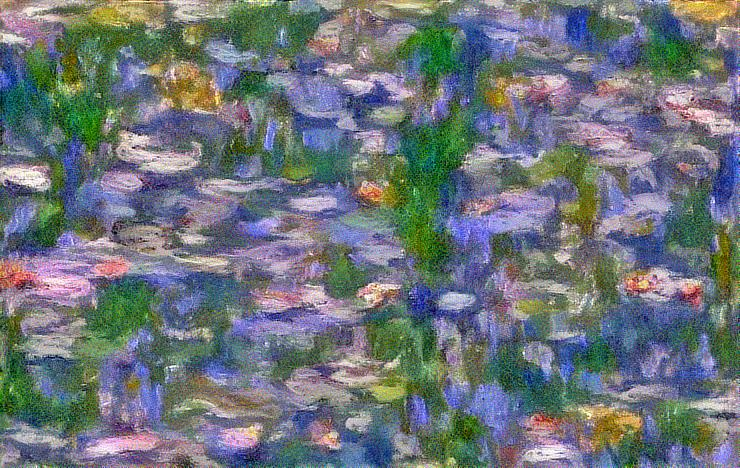

Iteration 100 completed in 19s
Current loss value: 6403469.5



In [18]:
x = np.random.uniform(0, 255, result_image.shape) - 128.
res = run(evaluator_with_variation, x, num_iter=100)

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
w, h = load_img(base_image_path).size
base_image = K.variable(preprocess_image(base_image_path))
style_image = K.variable(preprocess_image(style2_image_path, target_size=(h, w)))
combination_image = K.placeholder(style_image.shape)
input_tensor = K.concatenate([base_image, style_image,
                              combination_image], axis=0)

In [21]:
model = vgg16.VGG16(input_tensor=input_tensor, 
                    weights="imagenet", include_top=False)
print("Model loaded")

Model loaded


In [24]:
feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]
loss_content = content_loss(feature_outputs[-1][0, :, :, :], 
                            feature_outputs[-1][2, :, :, :])
loss_variation = total_variation_loss(combination_image)
loss_style = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style += style_loss(layer_features[1, :, :, :], layer_features[2, :, :, :]) * (0.5 ** idx)
loss_content /= 40
loss_variation /= 10000

loss_total = loss_content + loss_variation + loss_style

W0708 14:08:05.294424 140378524911488 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


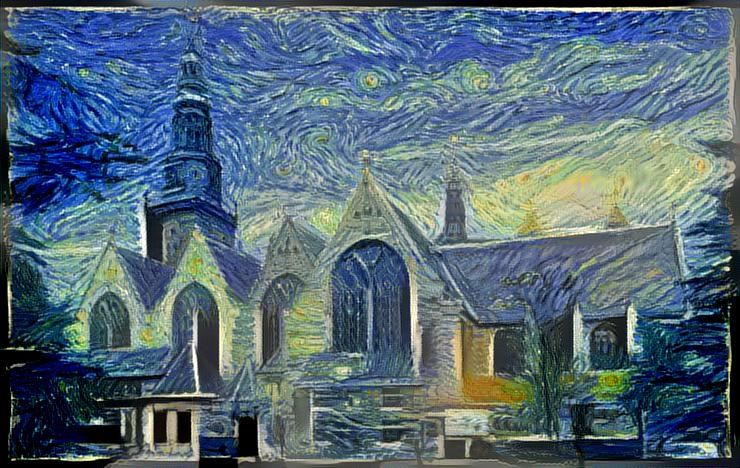

Iteration 100 completed in 24s
Current loss value: 1240656.5
loss_content:133957.25 loss_variation:838441.94 loss_style:268257.38


array([ -89.50922   , -106.75659179, -123.2166675 , ...,  -78.16098648,
       -121.9773012 , -133.38966753])

In [25]:
combined_evaluator = Evaluator(loss_total, combination_image, 
                               loss_content=loss_content,
                               loss_variation=loss_variation, 
                               loss_style=loss_style)

run(combined_evaluator, preprocess_image(base_image_path), num_iter=100)

In [0]:
w, h = load_img(base_image_path).size
base_image = K.variable(preprocess_image(base_image_path))
winter_style_image = K.variable(preprocess_image('style_transfer/road-to-versailles-at-louveciennes.jpg',
                                                 target_size=(h, w)))
summer_style_image = K.variable(preprocess_image('style_transfer/VanGogh_Farmhouse.jpeg', target_size=(h, w)))
combination_image = K.placeholder(summer_style_image.shape)
input_tensor = K.concatenate([base_image,
                              summer_style_image,
                              winter_style_image,
                              combination_image], axis=0)

In [0]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

In [0]:

feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]

loss_content = content_loss(feature_outputs[-1][0, :, :, :],
                            feature_outputs[-1][2, :, :, :])
loss_variation = total_variation_loss(combination_image)

loss_style_summer = K.variable(0.)
loss_style_winter = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style_summer += style_loss(layer_features[1, :, :, :], layer_features[-1, :, :, :]) * (0.5 ** idx)
    loss_style_winter += style_loss(layer_features[2, :, :, :], layer_features[-1, :, :, :]) * (0.5 ** idx)

loss_content /= 40
loss_variation /= 10000

summerness = K.placeholder()
loss_total = (loss_content + loss_variation + 
              loss_style_summer * summerness + 
              loss_style_winter * (1 - summerness))

In [0]:
combined_evaluator = Evaluator(loss_total, combination_image, loss_content=loss_content, 
                               loss_variation=loss_variation, loss_style_summer=loss_style_summer,
                               loss_style_winter=loss_style_winter)
iterate = K.function([combination_image, summerness], 
                     combined_evaluator.iterate.outputs)
combined_evaluator.iterate = lambda inputs: iterate(inputs + [0.5])
res = run(combined_evaluator, preprocess_image(base_image_path), num_iter=50)

In [0]:
import imageio

path = 'style_transfer/summer_winter_%d.jpg'
def save(res, step):
    img = deprocess_image(res.copy(), h, w)
    imageio.imwrite(path % step, img)
    
for step in range(1, 21):
    combined_evaluator = Evaluator(loss_total, combination_image, loss_content=loss_content, 
                                   loss_variation=loss_variation, loss_style_summer=loss_style_summer,
                                   loss_style_winter=loss_style_winter)
    iterate = K.function([combination_image, summerness], 
                         combined_evaluator.iterate.outputs)

    combined_evaluator.iterate = lambda inputs: iterate(inputs + [1.0 - step / 20.])
    res = run(combined_evaluator, preprocess_image(base_image_path), num_iter=50)
    save(res, step)

In [0]:
frames = glob.glob('style_transfer/summer_winter_*.jpg')
frames = sorted(frames, key=lambda f:int(f.split('.', 1)[0].rsplit('_', 1)[-1]))
cycled = frames + list(reversed(frames[1:-1]))
# Save them as frames into a gif 
kargs = { 'duration': 0.1 }
imageio.mimsave('style_transfer/animated.gif', [imageio.imread(x) for x in cycled], 'GIF', **kargs)

HTML('<img src="style_transfer/animated.gif">')